In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

%matplotlib inline
# sns.set_context('paper', font_scale=1.5)

import os, glob
from pathlib import Path
from scipy import stats, interpolate, signal
from scipy.signal import welch, butter, filtfilt
from HelperFcns import *

%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook

In [60]:
#load data
df = pd.read_csv('../Metadata/Poses.csv')
# df = pd.read_csv('/Users/luca/Box/CISPD_Videos_proc/Metadata/Poses.csv')
df.rename(columns={'Unnamed: 0':'frame#'}, inplace=True)
df.set_index(df['frame#'], inplace=True)
df.drop(['frame#'], axis=1, inplace=True)
df.head()

SubjID  Task  cycle   elbR_x   elbR_y    elbR_c   wriR_x   wriR_y  \
frame#                                                                      
0         1004  FtnL      1  329.352  329.357  0.899764  360.768  385.545   
1         1004  FtnL      1  329.346  328.036  0.889666  360.735  381.679   
2         1004  FtnL      1  329.380  324.163  0.856091  360.758  380.347   
3         1004  FtnL      1  329.406  318.941  0.898018  360.764  376.411   
4         1004  FtnL      1  329.426  313.724  0.841354  360.779  371.164   

          wriR_c   elbL_x  ...   midL_x   midL_y    midL_c  ringL_x  ringL_y  \
frame#                     ...                                                 
0       0.824514  463.882  ...  543.452  254.301  0.061957  540.300  256.777   
1       0.862279  465.103  ...  539.815  254.932  0.129784  539.146  254.932   
2       0.878291  465.108  ...  540.327  252.768  0.159085  539.872  255.268   
3       0.820703  465.154  ...  539.706  247.097  0.259074  539.035  246.874   
4       0.881449  465.153  ...  532.671  245.415  0.126552  531.071  245.872   

         ringL_c  pinkyL_x  pinkyL_y  pinkyL_c  Npeople  
frame#                                                   
0       0.078977   539.850   256.777  0.089969        3  
1       0.119539   532.907   253.149  0.160184        3  
2       0.124295   532.826   250.950  0.132498        3  
3       0.156923   537.918   246.427  0.176433        3  
4       0.097432   530.843   245.415  0.095396        3  

[5 rows x 55 columns]

In [4]:
scores = pd.read_csv('../Metadata/Table4.csv')
scores.TaskAbb.unique()

array(['Drnkg', 'Drwg', 'Fldg', 'FtnL', 'FtnR', 'NtsBts', 'RamL', 'RamR',
       'Sheets', 'Sitng', 'SitStand', 'Stndg', 'Typg', 'Wlkg', 'WlkgCnt'],
      dtype=object)

## Select patients with either no symptoms or high bradykinesia

In [7]:
# scores = pd.read_csv('/Users/luca/Box/CISPD_Videos_proc/Metadata/Table4.csv')
tasks = ['FtnL', 'FtnR', 'RamL', 'RamR', 'SitStand']
scores = pd.read_csv('../Metadata/Table4.csv')
scores = scores.loc[(scores['SubjID'].isin(df.SubjID.unique())) & (scores.TaskAbb.isin(tasks))]
scores = scores[['SubjID','Visit','TaskAbb','Tremor - Left', 'Tremor - Right', 'Bradykinesia - Right', 'Bradykinesia - Left']]
scores.query('Visit != "1 Month"', inplace=True)
scores['Visit']=scores.Visit.apply(lambda x: x.split()[-1])
for i,j in enumerate(scores.Visit.unique()):
    print(i,j)
    scores.loc[scores.Visit==j, 'Visit'] = i+1
scores = scores.query('Visit ==1 | Visit ==2 | Visit==3')
scores.head(2)

0 0
1 30
2 60
3 90
4 120
5 150


SubjID  Visit TaskAbb  Tremor - Left  Tremor - Right  \
108    1004      1    FtnL            1.0             0.0   
109    1004      1    FtnR            0.0             1.0   

     Bradykinesia - Right  Bradykinesia - Left  
108                   NaN                  1.0  
109                   1.0                  NaN

In [8]:
#subjects with severe symptoms
PD = scores.loc[(scores['Tremor - Left']>=2) | (scores['Tremor - Right']>=2) | 
           (scores['Bradykinesia - Left']>=2) | (scores['Bradykinesia - Right']>=2)]

noPD = scores.loc[(scores['Tremor - Left']==0) & (scores['Tremor - Right']==0) | 
           (scores['Bradykinesia - Left']==0) & (scores['Bradykinesia - Right']==0)]

PDsubj = PD.SubjID.unique()
noPDsubj = noPD.SubjID.unique()
print('high symptoms',PDsubj, '\nno symptoms',noPDsubj)

high symptoms [1004 1009 1039 1043 1044 1052 1054 1056] 
no symptoms [1004 1009 1023 1039 1043 1044 1052 1054]


In [70]:
PD.query('TaskAbb=="SitStand"')

SubjID  Visit   TaskAbb  Tremor - Left  Tremor - Right  \
2875    1056      1  SitStand            2.0             2.0   
2890    1056      2  SitStand            2.0             2.0   
2905    1056      3  SitStand            3.0             2.0   

      Bradykinesia - Right  Bradykinesia - Left  
2875                   NaN                  NaN  
2890                   NaN                  NaN  
2905                   NaN                  NaN

##  Right side

In [9]:
#no symptoms right side
tasksR = ['FtnR','RamR']
no_bradyR=scores.loc[(scores['TaskAbb'].isin(tasksR)) & (scores['Bradykinesia - Right']<1) &
          (scores['Tremor - Right']<1) & (scores['Tremor - Left'] < 1)].copy()
no_bradyR['symptom'] = 0
no_bradyR.SubjID.unique()

array([1004, 1009, 1023, 1039, 1043, 1044, 1052, 1054], dtype=int64)

In [10]:
#bradkinesia in right side 
bradyR = scores.loc[(scores['Bradykinesia - Right']>=1) & (scores['TaskAbb'].isin(tasksR))].copy()
bradyR['symptom'] = 1
bradyR.SubjID.unique()

array([1004, 1009, 1023, 1039, 1043, 1052, 1054, 1056], dtype=int64)

In [11]:
symptom = pd.concat((bradyR,no_bradyR))
symptom.rename(columns={'Visit':'cycle', 'TaskAbb':'Task'},inplace=True)
symptom = symptom[['SubjID','cycle','Task','symptom']]

#join with main df with joint coords
df['frame#'] = df.index
dfwSymptoms = pd.merge(df, symptom, left_on=['SubjID','Task','cycle'], right_on=['SubjID','Task','cycle'])
dfwSymptoms.set_index(dfwSymptoms['frame#'], inplace=True)

In [68]:
bradyR.query('TaskAbb=="FtnR"')

SubjID  Visit TaskAbb  Tremor - Left  Tremor - Right  \
109     1004      1    FtnR            0.0             1.0   
409     1009      1    FtnR            1.0             0.0   
424     1009      2    FtnR            0.0             0.0   
934     1023      1    FtnR            1.0             1.0   
949     1023      2    FtnR            1.0             1.0   
1564    1039      1    FtnR            0.0             0.0   
1669    1043      1    FtnR            2.0             1.0   
1684    1043      2    FtnR            0.0             1.0   
2689    1054      1    FtnR            0.0             1.0   
2704    1054      2    FtnR            0.0             0.0   
2869    1056      1    FtnR            0.0             2.0   
2884    1056      2    FtnR            2.0             2.0   
2899    1056      3    FtnR            3.0             2.0   

      Bradykinesia - Right  Bradykinesia - Left  symptom  
109                    1.0                  NaN        1  
409                    1.0                  NaN        1  
424                    1.0                  NaN        1  
934                    1.0                  NaN        1  
949                    1.0                  NaN        1  
1564                   1.0                  NaN        1  
1669                   3.0                  NaN        1  
1684                   2.0                  NaN        1  
2689                   2.0                  NaN        1  
2704                   1.0                  NaN        1  
2869                   1.0                  NaN        1  
2884                   1.0                  NaN        1  
2899                   1.0                  NaN        1

In [59]:
symptom.head(2)

SubjID  cycle  Task  symptom
412     1009      1  RamR        1
1669    1043      1  FtnR        1

In [60]:
symptom[symptom.symptom==0].head(3)

SubjID  cycle  Task  symptom
124    1004      2  FtnR        0
127    1004      2  RamR        0
139    1004      3  FtnR        0

In [61]:
symptom.query('Task=="FtnR"')

SubjID  cycle  Task  symptom
1669    1043      1  FtnR        1
1684    1043      2  FtnR        1
2689    1054      1  FtnR        1
124     1004      2  FtnR        0
139     1004      3  FtnR        0
439     1009      3  FtnR        0
1579    1039      2  FtnR        0
1594    1039      3  FtnR        0
1699    1043      3  FtnR        0
1774    1044      1  FtnR        0
1789    1044      2  FtnR        0
1804    1044      3  FtnR        0
2524    1052      2  FtnR        0
2539    1052      3  FtnR        0
2719    1054      3  FtnR        0

## Example joint trajectory for high bradykinesia vs no symptom

### Ftn

In [60]:
bradyR.query('TaskAbb=="FtnR"').sort_values(by=['Bradykinesia - Right'], ascending=False)

SubjID  Visit TaskAbb  Tremor - Left  Tremor - Right  \
1669    1043      1    FtnR            2.0             1.0   
1684    1043      2    FtnR            0.0             1.0   
2689    1054      1    FtnR            0.0             1.0   
109     1004      1    FtnR            0.0             1.0   
409     1009      1    FtnR            1.0             0.0   
424     1009      2    FtnR            0.0             0.0   
934     1023      1    FtnR            1.0             1.0   
949     1023      2    FtnR            1.0             1.0   
1564    1039      1    FtnR            0.0             0.0   
2704    1054      2    FtnR            0.0             0.0   
2869    1056      1    FtnR            0.0             2.0   
2884    1056      2    FtnR            2.0             2.0   
2899    1056      3    FtnR            3.0             2.0   

      Bradykinesia - Right  Bradykinesia - Left  symptom  
1669                   3.0                  NaN        1  
1684                   2.0                  NaN        1  
2689                   2.0                  NaN        1  
109                    1.0                  NaN        1  
409                    1.0                  NaN        1  
424                    1.0                  NaN        1  
934                    1.0                  NaN        1  
949                    1.0                  NaN        1  
1564                   1.0                  NaN        1  
2704                   1.0                  NaN        1  
2869                   1.0                  NaN        1  
2884                   1.0                  NaN        1  
2899                   1.0                  NaN        1

<IPython.core.display.Javascript object>


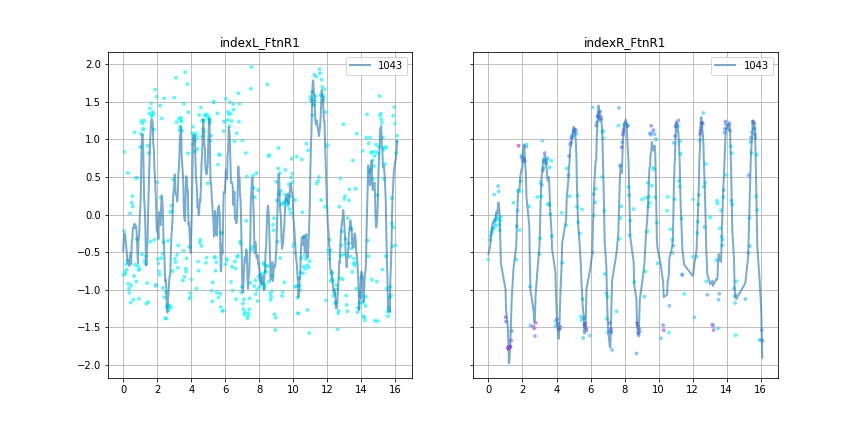

In [56]:
plot_joint_trajectory(df, subjs=['1043'], cycle=1, joint='index', colormap=True) #high bradykinesia
plt.savefig('../Figs/1043_wri_3.jpg',dpi=300)

<IPython.core.display.Javascript object>


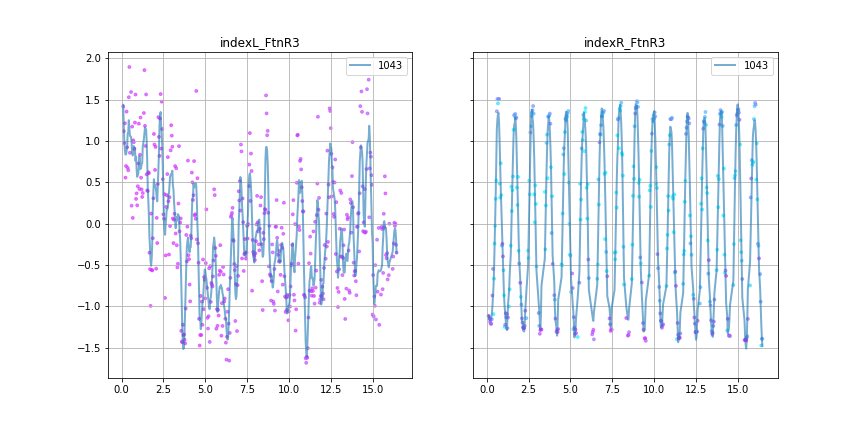

In [57]:
plot_joint_trajectory(df, subjs=['1043'], cycle=3, joint='index', colormap=True) #no bradykinesia

<IPython.core.display.Javascript object>


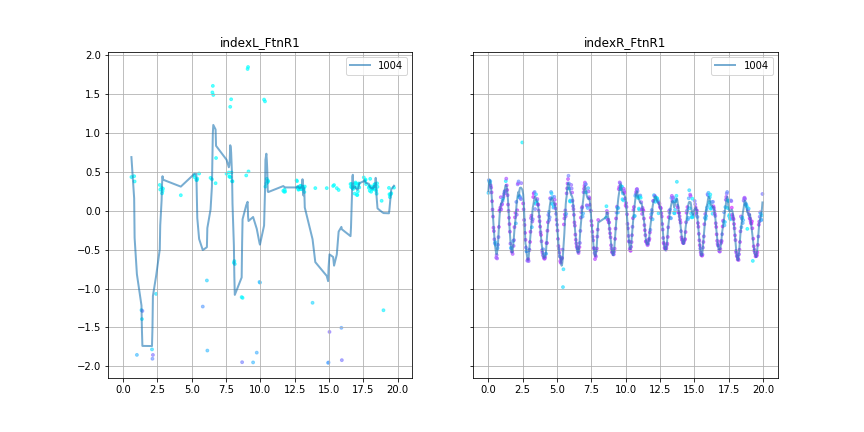

In [67]:
plot_joint_trajectory(df, subjs=['1004'], cycle=1, joint='index', colormap=True) #low bradykinesia

In [61]:
no_bradyR.query('TaskAbb=="FtnR"').sort_values(by=['Bradykinesia - Right'], ascending=False)

SubjID  Visit TaskAbb  Tremor - Left  Tremor - Right  \
124     1004      2    FtnR            0.0             0.0   
139     1004      3    FtnR            0.0             0.0   
439     1009      3    FtnR            0.0             0.0   
1579    1039      2    FtnR            0.0             0.0   
1594    1039      3    FtnR            0.0             0.0   
1699    1043      3    FtnR            0.0             0.0   
1774    1044      1    FtnR            0.0             0.0   
1789    1044      2    FtnR            0.0             0.0   
1804    1044      3    FtnR            0.0             0.0   
2524    1052      2    FtnR            0.0             0.0   
2539    1052      3    FtnR            0.0             0.0   
2719    1054      3    FtnR            0.0             0.0   

      Bradykinesia - Right  Bradykinesia - Left  symptom  
124                    0.0                  NaN        0  
139                    0.0                  NaN        0  
439                    0.0                  NaN        0  
1579                   0.0                  NaN        0  
1594                   0.0                  NaN        0  
1699                   0.0                  NaN        0  
1774                   0.0                  NaN        0  
1789                   0.0                  NaN        0  
1804                   0.0                  NaN        0  
2524                   0.0                  NaN        0  
2539                   0.0                  NaN        0  
2719                   0.0                  NaN        0

<IPython.core.display.Javascript object>


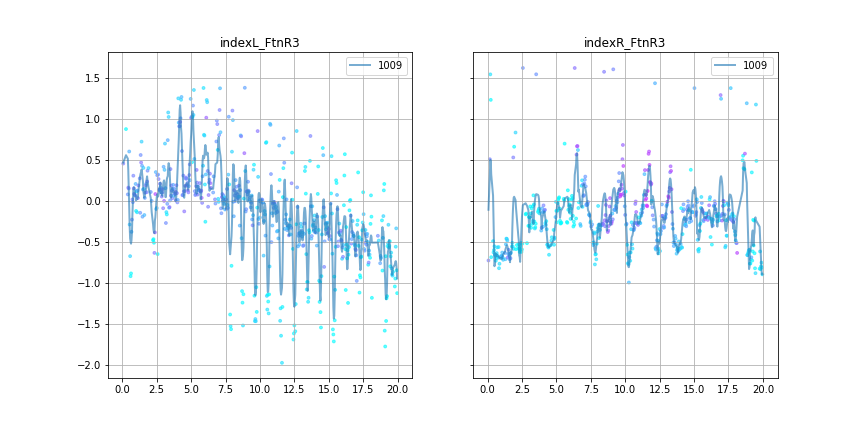

In [65]:
plot_joint_trajectory(df, subjs=['1009'], cycle=3, joint='index', colormap=True) #no bradykinesia but poor tracking/detections

### Ram

In [28]:
df1043 = df.query('SubjID==1043 & cycle==1 & Task=="RamR"').copy()
df1043.head()

SubjID  Task  cycle   elbR_x   elbR_y    elbR_c   wriR_x   wriR_y  \
frame#                                                                      
0         1043  RamR      1  357.379  204.622  0.780525  392.581  167.865   
1         1043  RamR      1  358.792  204.625  0.785619  392.648  164.967   
2         1043  RamR      1  358.791  204.574  0.781337  392.665  162.056   
3         1043  RamR      1  358.821  204.565  0.793570  392.631  160.596   
4         1043  RamR      1  360.281  204.688  0.788019  392.644  157.647   

          wriR_c   elbL_x  ...   midL_y    midL_c  ringL_x  ringL_y   ringL_c  \
frame#                     ...                                                  
0       0.817459  570.282  ...  453.904  0.454282  581.454  453.904  0.466785   
1       0.808102  570.307  ...  454.302  0.515490  582.168  454.654  0.480434   
2       0.807413  570.325  ...  454.262  0.387719  581.201  454.955  0.438076   
3       0.814387  570.300  ...  454.614  0.422397  580.966  454.956  0.428301   
4       0.809475  570.315  ...  454.818  0.385895  580.777  455.863  0.389993   

        pinkyL_x  pinkyL_y  pinkyL_c  Npeople  frame#  
frame#                                                 
0        587.538   448.177  0.397253        1       0  
1        587.439   448.680  0.431739        1       1  
2        587.435   450.106  0.331173        1       2  
3        586.439   448.457  0.346673        1       3  
4        587.050   450.984  0.358833        1       4  

[5 rows x 56 columns]

In [64]:
#test with coords calculated from deeplabcut inference
df_deepcut = pd.read_csv('c:/Users/llonini/Box/CISPD_Videos_proc/PoseVideos/1043/DeepCut/1043_RamR_deepcut.csv')
df_deepcut.rename(columns={'x':'thumbR_x', 'y':'thumbR_y', 'likelihood':'thumbR_c',
                          'x.1':'pinkyR_x', 'y.1':'pinkyR_y', 'likelihood.1':'pinkyR_c'}, inplace=True)
df_deepcut.drop('coords',axis=1,inplace=True)
df_deepcut.index= df1043.index
df.loc[(df.SubjID==1043) & (df.cycle==1) & (df.Task=='RamR'), df_deepcut.columns] = df_deepcut

In [65]:
bradyR.query('TaskAbb=="RamR"').sort_values(by=['Bradykinesia - Right'], ascending=False)

SubjID  Visit TaskAbb  Tremor - Left  Tremor - Right  \
1672    1043      1    RamR            2.0             2.0   
1687    1043      2    RamR            1.0             1.0   
2887    1056      2    RamR            1.0             2.0   
2872    1056      1    RamR            2.0             1.0   
2692    1054      1    RamR            0.0             0.0   
2512    1052      1    RamR            0.0             1.0   
412     1009      1    RamR            1.0             0.0   
2902    1056      3    RamR            3.0             2.0   
1582    1039      2    RamR            0.0             0.0   
1567    1039      1    RamR            0.0             0.0   
2527    1052      2    RamR            0.0             0.0   
2542    1052      3    RamR            0.0             0.0   
937     1023      1    RamR            0.0             0.0   
2722    1054      3    RamR            0.0             0.0   
442     1009      3    RamR            1.0             0.0   
427     1009      2    RamR            1.0             0.0   
112     1004      1    RamR            0.0             1.0   

      Bradykinesia - Right  Bradykinesia - Left  symptom  
1672                   3.0                  NaN        1  
1687                   2.0                  NaN        1  
2887                   2.0                  NaN        1  
2872                   2.0                  NaN        1  
2692                   2.0                  NaN        1  
2512                   2.0                  NaN        1  
412                    2.0                  NaN        1  
2902                   2.0                  NaN        1  
1582                   1.0                  NaN        1  
1567                   1.0                  NaN        1  
2527                   1.0                  NaN        1  
2542                   1.0                  NaN        1  
937                    1.0                  NaN        1  
2722                   1.0                  NaN        1  
442                    1.0                  NaN        1  
427                    1.0                  NaN        1  
112                    1.0                  NaN        1

<IPython.core.display.Javascript object>


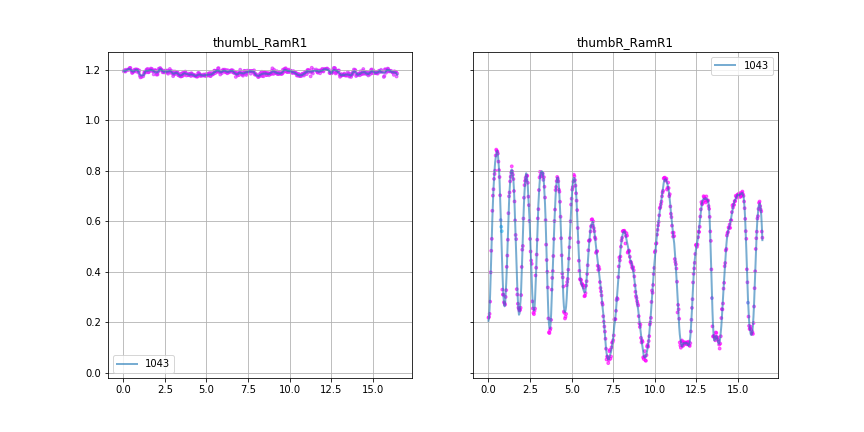

In [59]:
plot_joint_trajectory(df, subjs=['1043'], task='RamR', cycle=1, joint='thumb', colormap=True, zscore=False) #high bradykinesia and tremor - poor tracking

frac detection missing: 0.022222222222222223


<IPython.core.display.Javascript object>


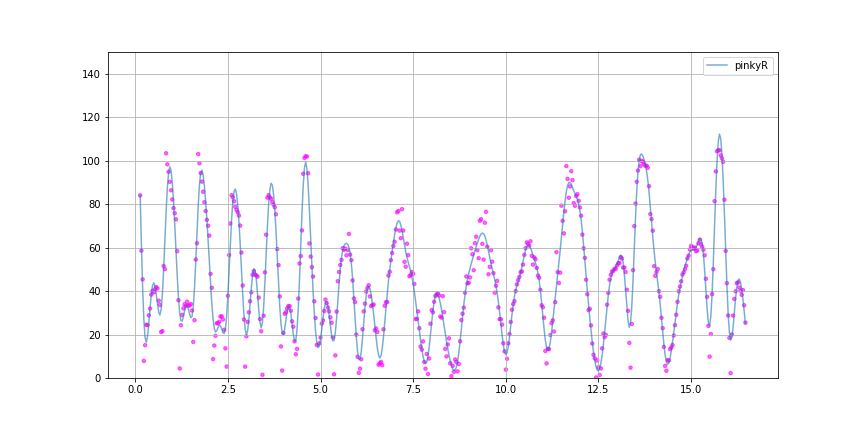

median confidence pinkyR = 0.999227285


(0, 150)

In [66]:
plot_hand_orientation(df, s=['1043'], cycle=1, fingers=['pinkyR']) #high bradykinesia and tremor - poor tracking
plt.ylim([0,150])

<IPython.core.display.Javascript object>


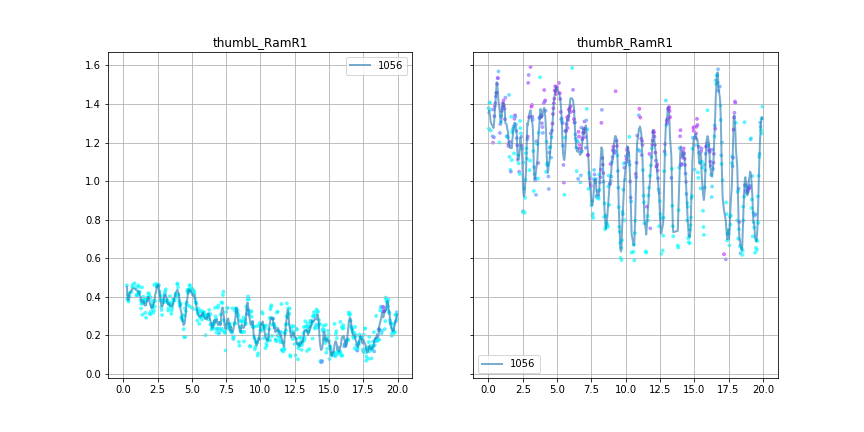

In [77]:
#high bradykinesia - real drift - large body sways
plot_joint_trajectory(df, subjs=['1056'], task='RamR', joint='thumb', cycle=1, colormap=True, zscore=False) 

frac detection missing: 0.04383116883116883


<IPython.core.display.Javascript object>


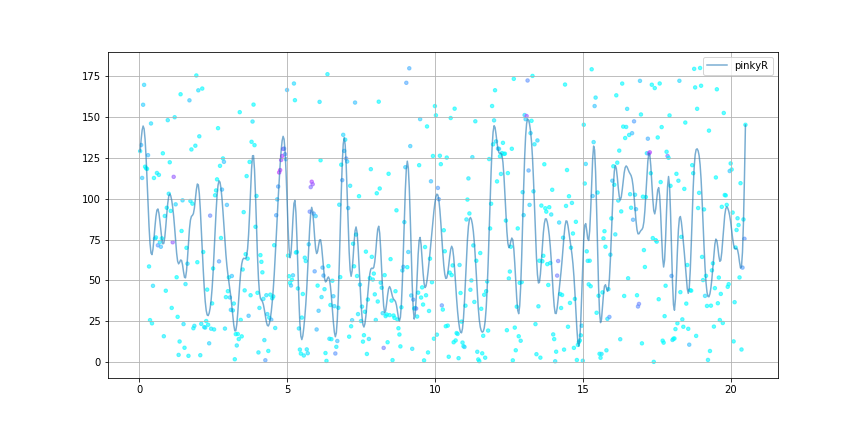

median confidence pinkyR = 0.0282548


In [31]:
plot_hand_orientation(df, s=['1056'], cycle=1, fingers=['pinkyR'])

<IPython.core.display.Javascript object>


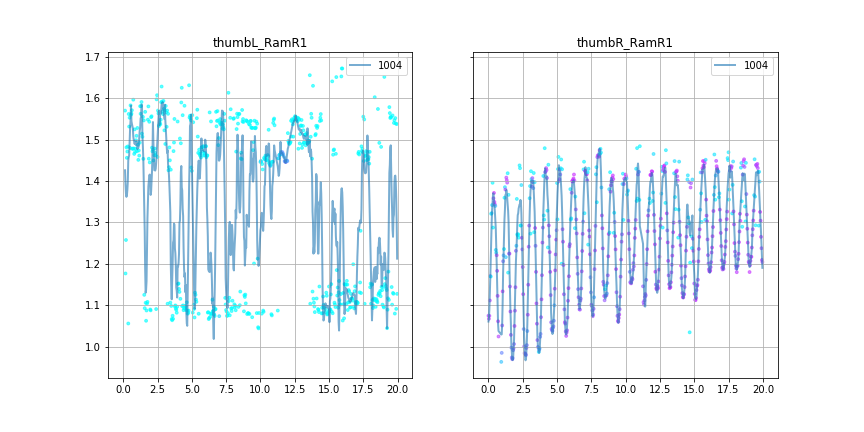

In [47]:
plot_joint_trajectory(df, subjs=['1004'], task='RamR', joint='thumb', cycle=1, colormap=True, zscore=False) #good tracking

frac detection missing: 0.006965174129353234


<IPython.core.display.Javascript object>


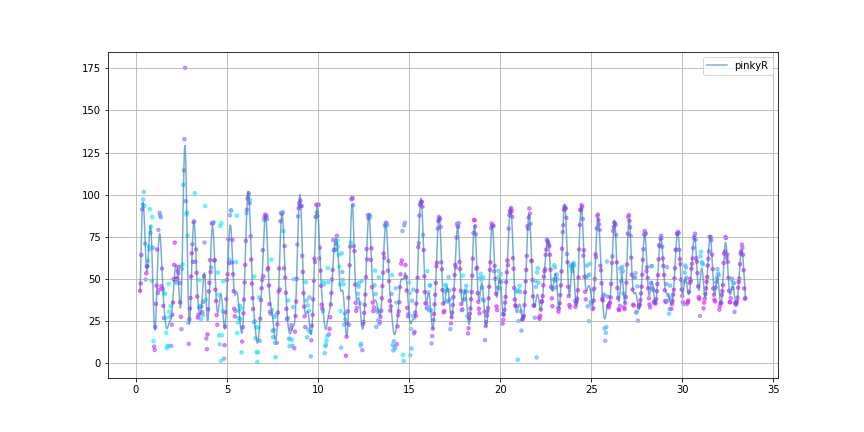

median confidence pinkyR = 0.721951


In [45]:
plot_hand_orientation(df, s=['1004'], cycle=1, fingers=['pinkyR']) #decreasing amplitude - this is correct

frac detection missing: 0.05506607929515418


<IPython.core.display.Javascript object>


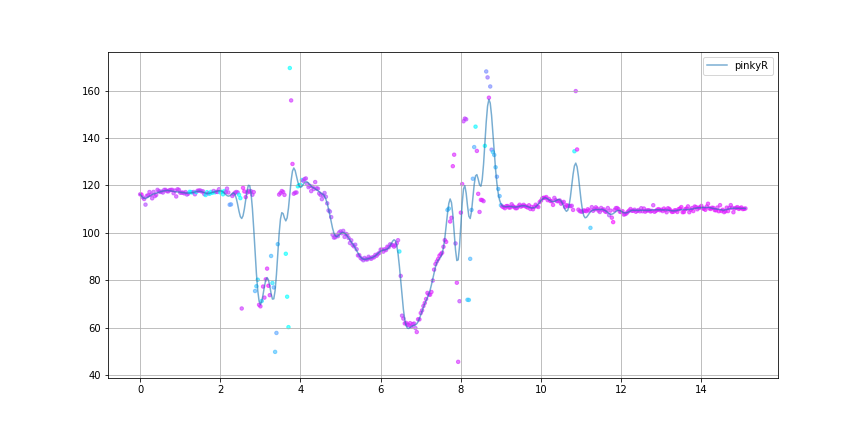

median confidence pinkyR = 0.8080080000000001


In [80]:
plot_hand_orientation(df, s=['1009'], cycle=1, fingers=['pinkyR']) #poor tracking high confidence

<IPython.core.display.Javascript object>


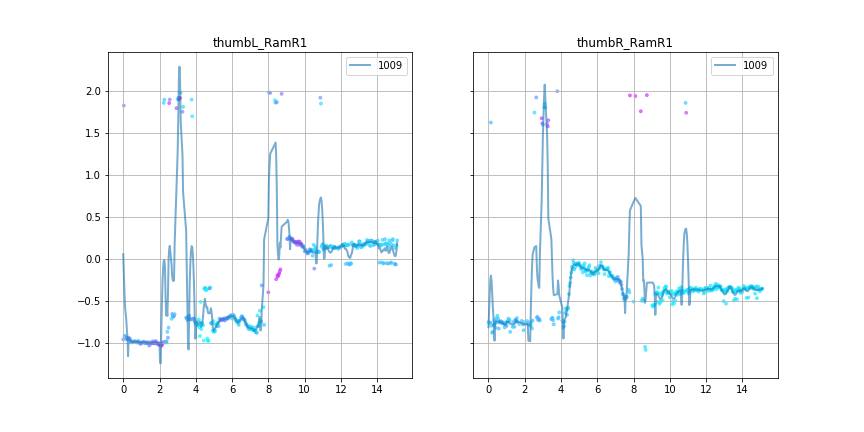

In [93]:
plot_joint_trajectory(df, subjs=['1009'], task='RamR', joint='thumb', cycle=1, colormap=True, zscore=True) 

### NO symptoms

In [32]:
no_bradyR.query('TaskAbb=="RamR"').sort_values(by=['Bradykinesia - Right'], ascending=False)

SubjID  Visit TaskAbb  Tremor - Left  Tremor - Right  \
127     1004      2    RamR            0.0             0.0   
142     1004      3    RamR            0.0             0.0   
952     1023      2    RamR            0.0             0.0   
967     1023      3    RamR            0.0             0.0   
1597    1039      3    RamR            0.0             0.0   
1702    1043      3    RamR            0.0             0.0   
1777    1044      1    RamR            0.0             0.0   
1792    1044      2    RamR            0.0             0.0   
1807    1044      3    RamR            0.0             0.0   
2707    1054      2    RamR            0.0             0.0   

      Bradykinesia - Right  Bradykinesia - Left  symptom  
127                    0.0                  NaN        0  
142                    0.0                  NaN        0  
952                    0.0                  NaN        0  
967                    0.0                  NaN        0  
1597                   0.0                  NaN        0  
1702                   0.0                  NaN        0  
1777                   0.0                  NaN        0  
1792                   0.0                  NaN        0  
1807                   0.0                  NaN        0  
2707                   0.0                  NaN        0

<IPython.core.display.Javascript object>


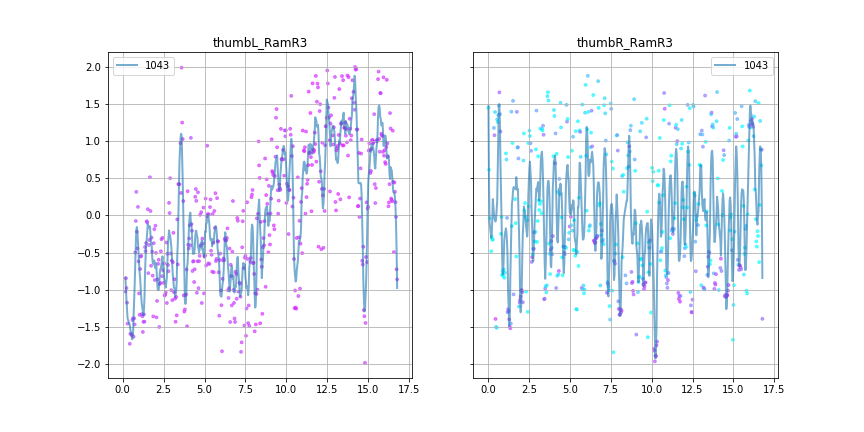

In [95]:
plot_joint_trajectory(df, subjs=['1043'], task='RamR', joint='thumb', cycle=3, colormap=True, zscore=True) #no bradykinesia but poor tracking/detections

frac detection missing: 0.01984126984126984


<IPython.core.display.Javascript object>


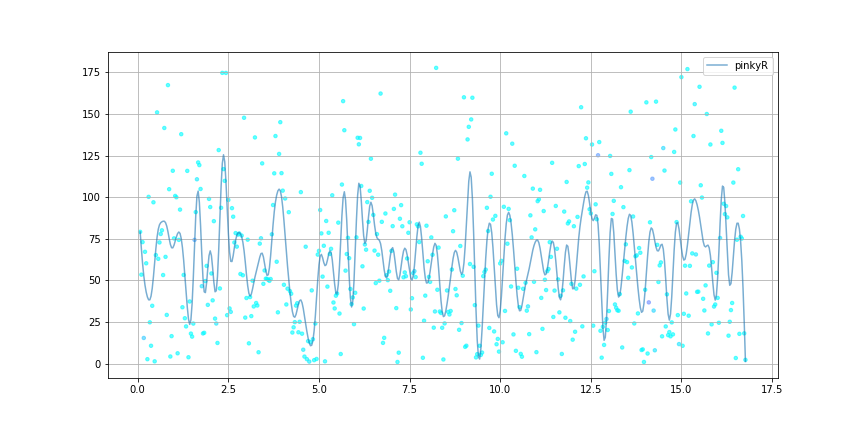

median confidence pinkyR = 0.01339835


In [34]:
plot_hand_orientation(df, s=['1043'], cycle=3, fingers=['pinkyR']) #no bradykinesia but poor tracking/detections

<IPython.core.display.Javascript object>


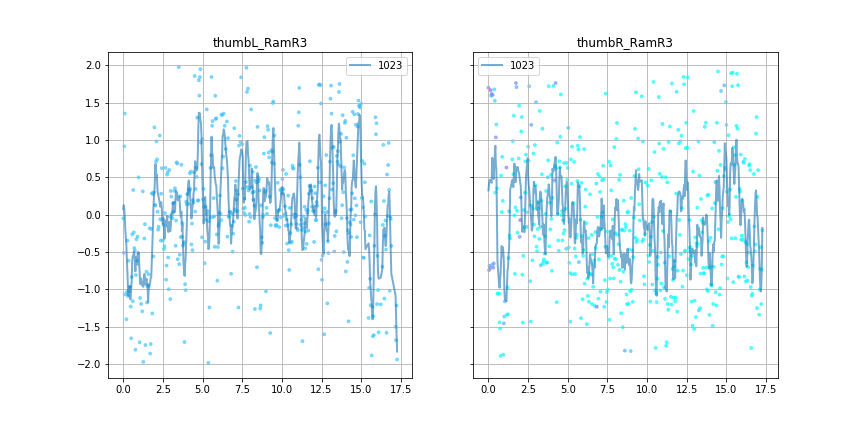

In [97]:
plot_joint_trajectory(df, subjs=['1023'], task='RamR', joint='thumb', cycle=3, colormap=True, zscore=True) #no bradykinesia but poor tracking/detections

frac detection missing: 0.0


<IPython.core.display.Javascript object>


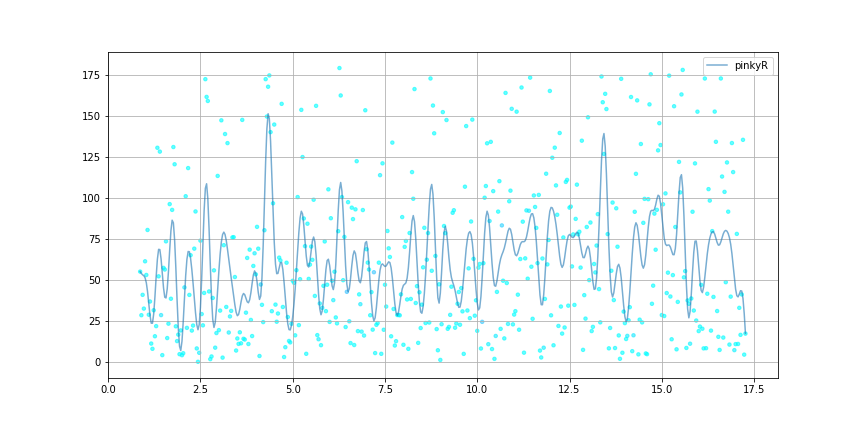

median confidence pinkyR = 0.00998302


In [100]:
plot_hand_orientation(df, s=['1023'], cycle=3, fingers=['pinkyR']) #no bradykinesia but poor tracking/detections

In [92]:
dfwSymptoms.query('Task=="FtnR"').SubjID.unique()

array([1004, 1009, 1039, 1043, 1044], dtype=int64)

In [46]:
dfwS

frame#
0      False
1      False
2      False
3      False
4      False
       ...  
611     True
612     True
613     True
614     True
615     True
Name: symptom, Length: 9589, dtype: bool

In [66]:
dfwSymptoms.query('Task=="FtnR"').SubjID.unique()

array([1004, 1009, 1039, 1043, 1044], dtype=int64)

<IPython.core.display.Javascript object>


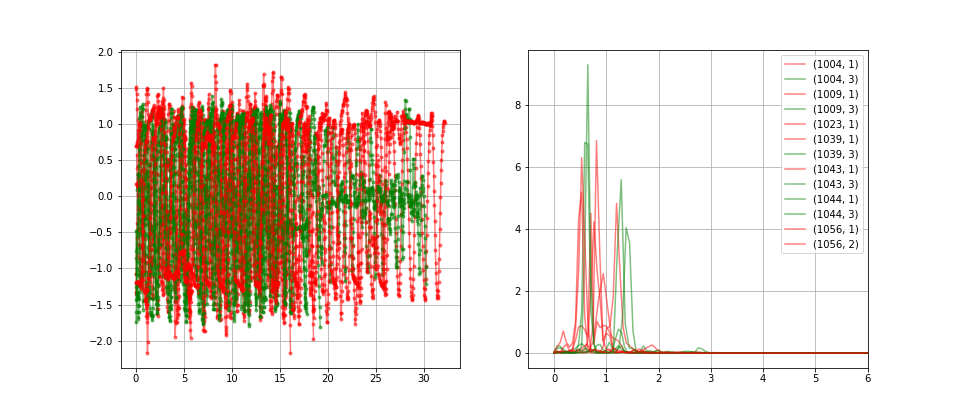

In [18]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
plot_PSD(dfwSymptoms, list(dfwSymptoms.SubjID.unique()), 'indexR_', 'FtnR', dfwSymptoms.cycle.unique(), ax, col=1)

<IPython.core.display.Javascript object>


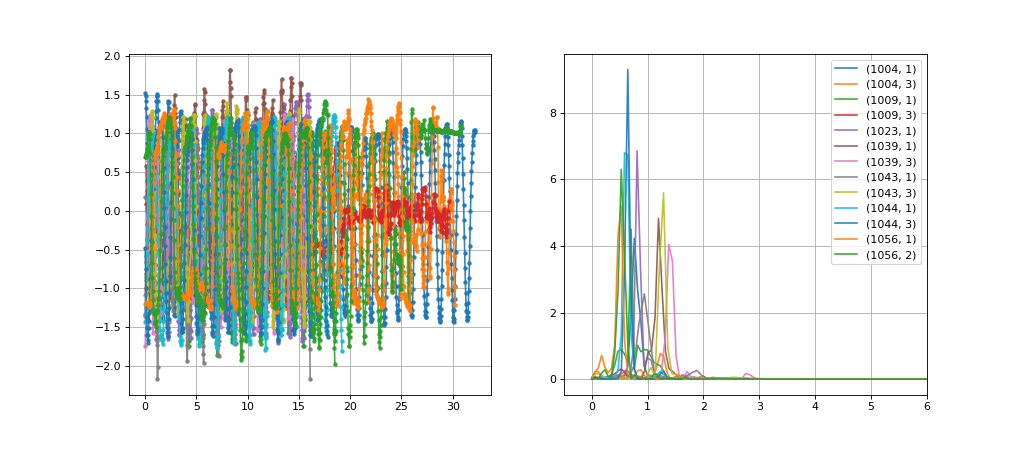

In [30]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
plot_PSD(dfwSymptoms, list(dfwSymptoms.SubjID.unique()), 'indexR_', 'FtnR', dfwSymptoms.cycle.unique(), ax, col=None, alpha=0.9)

<IPython.core.display.Javascript object>


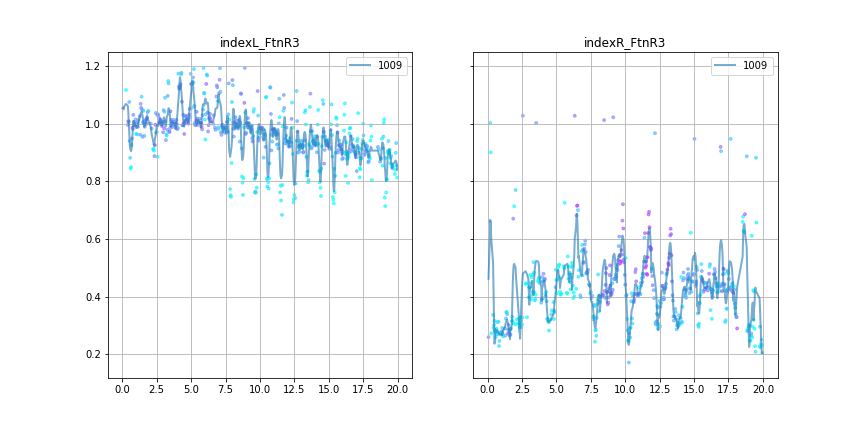

In [16]:
plot_joint_trajectory(df, subjs=['1009'], task='FtnR', joint='index',cycle=3, colormap=True, zscore=False) 

<IPython.core.display.Javascript object>


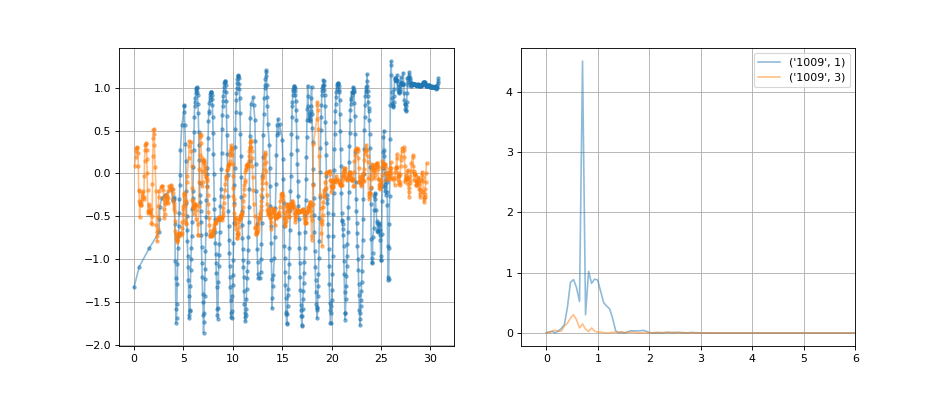

In [29]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
plot_PSD(dfwSymptoms, ['1009'], 'indexR_', 'FtnR', [1,3], ax, col=None)

<IPython.core.display.Javascript object>


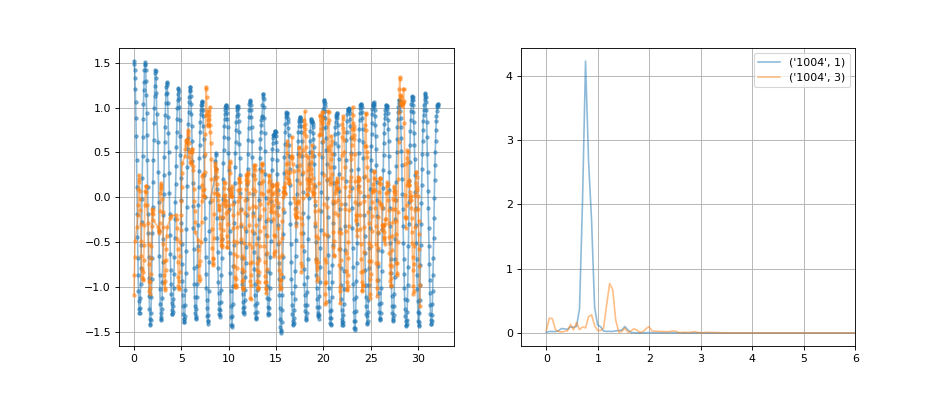

In [19]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
plot_PSD(dfwSymptoms, ['1004'], 'indexR_', 'FtnR', [1,3], ax, col=None)